### Import packeges

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
import joblib 
import gc
from pathlib import Path

In [17]:
# Define functions to calculate NDVI and NDWI
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-10)

def calculate_ndwi(nir, swir):
    return (nir - swir) / (nir + swir + 1e-10)

# Function to extract mean NDVI & NDWI as features
def extract_features(image_path):
    with rasterio.open(image_path) as src:
        bands = src.read()
        nir, red, swir = bands[3], bands[2], bands[4]  # Adjust based on band order
        
        ndvi = calculate_ndvi(nir, red)
        ndwi = calculate_ndwi(nir, swir)

        return [np.mean(ndvi), np.mean(ndwi)]  # Use mean as feature

In [ ]:
# Load dataset efficiently
train_dataset_path = Path('../../../data/model/Train/')
test_dataset_path = Path('../../../data/model/Test/')
growth_stages = ["germination", "tillering", "grand_growth", "ripening"]
X, X_test, y, y_test = [], [], [], []

for idx, stage in enumerate(growth_stages):
    stage_path = os.path.join(test_dataset_path, stage)
    for img_file in os.listdir(stage_path):
        img_path = os.path.join(stage_path, img_file)
        X.append(extract_features(img_path))
        y.append(idx)

X = np.array(X)
y = np.array(y)

#gc.collect()

for idx, stage in enumerate(growth_stages):
    stage_path = os.path.join(test_dataset_path, stage)
    for img_file in os.listdir(stage_path):
        img_path = os.path.join(stage_path, img_file)
        X_test.append(extract_features(img_path))
        y_test.append(idx)

X_test = np.array(X_test)
y_test = np.array(y_test)

#gc.collect()

c:\Users\user\anaconda3\envs\research_env\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


#### Apply k-Fold Cross-Validation and GridSearchCV

In [ ]:
# Define parameter grid for SVM
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", "auto", 0.01, 0.1],
    "kernel": ["rbf", "linear"]
}

# Initialize SVM and GridSearchCV
svm_model = SVC()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(svm_model, param_grid, cv=kf, n_jobs=-1, verbose=2)

# Train model with cross-validation
grid_search.fit(X, y)

# Get the best model from Grid Search
best_model = grid_search.best_estimator_

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Train the model on the entire training dataset
best_model.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


SVC(C=10)

#### Evaluate Model

Test Accuracy: 0.7692307692307693
Test Precision: 0.7547150997150996
Test Recall: 0.7692307692307693
Test F1 Score: 0.7238971262330551
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.98      0.88        97
           1       0.67      0.08      0.14        26
           2       0.73      0.85      0.79        39
           3       0.74      0.61      0.67        33

    accuracy                           0.77       195
   macro avg       0.73      0.63      0.62       195
weighted avg       0.75      0.77      0.72       195

Saved model to: ..\models\svm_model_v2.joblib
Best Cross-Validation Accuracy: 75.38%


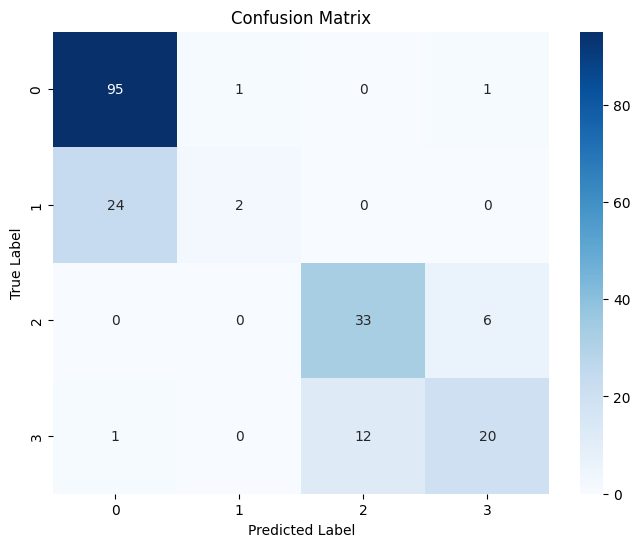

In [ ]:
# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

# Calculate additional metrics
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
confusion = confusion_matrix(y_test, y_test_pred)

# Log confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(Path("../../../logs/IMG/SVM_V2_confusion_matrix.png")) # Save confusion matrix

# Print results
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Classification Report:\n{test_report}")

# Save the best model to disk
svm_model_v2 = Path("../../../models/svm_model_v2.joblib")
joblib.dump(best_model, svm_model_v2)
print(f"Saved model to: {svm_model_v2}")

# Evaluate using cross-validation accuracy
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")


#### Predict New Images

In [ ]:
# Load the best model
best_model = joblib.load(Path("../../../models/svm_model_v2.joblib"))

def predict_growth_stage(image_path, model):
    features = extract_features(image_path)
    predicted_label = model.predict([features])[0]
    return growth_stages[predicted_label]

new_image = Path('../../../data/model/Test/ripening/ripening_100FPLAN_31.tif')
predicted_stage = predict_growth_stage(new_image, best_model)
print(f"Predicted Growth Stage: {predicted_stage}")

Predicted Growth Stage: ripening


c:\Users\user\anaconda3\envs\research_env\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
